In [2]:
# Cell 1: Import necessary libraries
# !pip install ortools
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import numpy as np
import random
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error
import time  # Import time module for measuring execution time


In [3]:
# Cell 2: Define the function to create the data model
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    # Updated distance matrix for 10 nodes
    data["distance_matrix"] = [  # actually a time matrix, just naming it distance_matrix
        [0, 6, 9, 8, 7, 3, 6, 2, 3, 2],
        [6, 0, 8, 3, 2, 6, 8, 4, 8, 8],
        [9, 8, 0, 11, 10, 6, 3, 9, 5, 8],
        [8, 3, 11, 0, 1, 7, 10, 6, 10, 10],
        [7, 2, 10, 1, 0, 6, 9, 4, 8, 9],
        [3, 6, 6, 7, 6, 0, 2, 3, 2, 2],
        [6, 8, 3, 10, 9, 2, 0, 6, 2, 5],
        [2, 4, 9, 6, 4, 3, 6, 0, 4, 4],
        [3, 8, 5, 10, 8, 2, 2, 4, 0, 3],
        [2, 8, 8, 10, 9, 2, 5, 4, 3, 0],
    ]
    # Updated time windows for 10 nodes
    data["time_windows"] = [
        (0, 5),  # depot
        (7, 12),  # 1
        (10, 15),  # 2
        (16, 18),  # 3
        (10, 13),  # 4
        (0, 5),  # 5
        (5, 10),  # 6
        (0, 4),  # 7
        (5, 10),  # 8
        (0, 3),  # 9
    ]
    data["num_vehicles"] = 4
    data["depot"] = 0
    return data

# Cell 3: Define constants and initialize the problem data
# Define constants
ALPHA = 1.0
BETA = 2.0
RHO = 0.1
Q = 100
NUM_ANTS = 10
MAX_ITER = 1000
TIME_WINDOW_PENALTY = 10
CAPACITY_PENALTY = 100

# Define the problem data
data = create_data_model()
distance_matrix = np.array(data["distance_matrix"])
num_nodes = len(distance_matrix)
time_windows = data["time_windows"]
demands = [0] * num_nodes
vehicle_capacity = 20
num_vehicles = data["num_vehicles"]


In [4]:
# Cell 4: Generate training data for the ML model
X_train = []
y_train = []

for i in range(num_nodes):
    for j in range(num_nodes):
        if i != j:
            dij = distance_matrix[i][j]
            delta_t = max(0, time_windows[j][1] - time_windows[i][0])
            qj = demands[j]
            heuristic = 1 / dij * (1 + delta_t / 10) * (1 - qj / vehicle_capacity)
            X_train.append([dij, delta_t, qj])
            y_train.append(heuristic)


In [5]:
# Cell 5: Train a decision tree regressor
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Predict heuristic values for the training set
y_pred = model.predict(X_train)

# Calculate and print the Mean Squared Error (MSE) for the training data
mse = root_mean_squared_error(y_train, y_pred)
print(f"Mean Squared Error (MSE) on Training Data: {mse:.4f}")


Mean Squared Error (MSE) on Training Data: 0.0000


In [6]:
# Cell 6: Define pheromone level initialization
def initialize_pheromone_levels(n, tau0):
    return np.ones((n, n)) * tau0

# Cell 7: Define heuristic value calculation
def heuristic_value(i, j):
    dij = distance_matrix[i][j]
    delta_t = max(0, time_windows[j][1] - time_windows[i][0])
    qj = demands[j]
    return model.predict([[dij, delta_t, qj]])[0]


# Cell 8: Construct a solution
def construct_solution(graph, pheromone, alpha, beta, num_ants):
    solutions = []
    for _ in range(num_ants):
        solution = []
        visited = set()
        current_node = 0
        visited.add(current_node)
        route = [current_node]
        while len(visited) < len(graph):
            feasible_nodes = [j for j in range(len(graph)) if j not in visited]
            if not feasible_nodes:
                break
            probabilities = [pheromone[current_node][j]**alpha * heuristic_value(current_node, j)**beta for j in feasible_nodes]
            total_prob = sum(probabilities)
            if total_prob == 0:
                probabilities = [1.0 / len(feasible_nodes)] * len(feasible_nodes)
            else:
                probabilities = [p / total_prob for p in probabilities]
            next_node = np.random.choice(feasible_nodes, p=probabilities)
            route.append(next_node)
            visited.add(next_node)
            current_node = next_node
        route.append(0)  # Return to depot
        solutions.append(route)
    return solutions

# Cell 9: Define functions for calculating tour length and penalties
def calculate_tour_length(tour):
    length = 0
    for i in range(len(tour) - 1):
        length += distance_matrix[tour[i]][tour[i + 1]]
    return length

# Apply time window penalty
def apply_time_window_penalty(route):
    penalty = 0
    current_time = 0
    for i in range(len(route) - 1):
        arrival_time = current_time + distance_matrix[route[i]][route[i + 1]]
        if arrival_time < time_windows[route[i + 1]][0]:
            current_time = time_windows[route[i + 1]][0]
        elif arrival_time > time_windows[route[i + 1]][1]:
            penalty += TIME_WINDOW_PENALTY
        current_time += distance_matrix[route[i]][route[i + 1]]
    return penalty

# Apply capacity constraints
def apply_capacity_constraints(route):
    current_demand = 0
    feasible = True
    for node in route:
        current_demand += demands[node]
        if current_demand > vehicle_capacity:
            feasible = False
            break
    return feasible

# Cell 10: Define pheromone update functions
# Local pheromone update
def local_pheromone_update(pheromone, solutions, rho, Q):
    for solution in solutions:
        tour_length = calculate_tour_length(solution)
        for i in range(len(solution) - 1):
            pheromone[solution[i]][solution[i + 1]] += Q / tour_length
            pheromone[solution[i + 1]][solution[i]] += Q / tour_length
    pheromone *= (1 - rho)
    return pheromone

# Global pheromone update
def global_pheromone_update(pheromone, best_solution, rho, Q):
    best_length = calculate_tour_length(best_solution)
    for i in range(len(best_solution) - 1):
        pheromone[best_solution[i]][best_solution[i + 1]] += Q / best_length
        pheromone[best_solution[i + 1]][best_solution[i]] += Q / best_length
    pheromone *= (1 - rho)
    return pheromone


# Cell 11: Define the Ant Colony Optimization algorithm
def ant_colony_optimization(data):
    num_nodes = len(data["distance_matrix"])
    pheromone = initialize_pheromone_levels(num_nodes, 1.0)
    best_solution = None
    best_length = float("inf")

    start_time = time.time()  # Start time measurement

    for iteration in range(MAX_ITER):
        solutions = construct_solution(data["distance_matrix"], pheromone, ALPHA, BETA, NUM_ANTS)
        for solution in solutions:
            length = calculate_tour_length(solution) + apply_time_window_penalty(solution)
            if apply_capacity_constraints(solution):
                if length < best_length:
                    best_length = length
                    best_solution = solution

        pheromone = local_pheromone_update(pheromone, solutions, RHO, Q)
        if best_solution:
            pheromone = global_pheromone_update(pheromone, best_solution, RHO, Q)

    end_time = time.time()  # End time measurement
    total_time = end_time - start_time  # Calculate total running time

    return best_solution, best_length, total_time


In [7]:
# Cell 12: Run the Ant Colony Optimization and print results
if __name__ == "__main__":
    best_solution, best_length, total_time = ant_colony_optimization(data)
    print("Best Solution:", best_solution)
    print("Best Length:", best_length)
    print(f"Total Running Time: {total_time:.2f} seconds")


Best Solution: [0, 9, 5, 8, 6, 2, 3, 4, 1, 7, 0]
Best Length: 81
Total Running Time: 91.28 seconds


Starting sensitivity analysis...

Analyzing sensitivity to tau0...

Analyzing sensitivity to alpha...

Analyzing sensitivity to beta...

Analyzing sensitivity to rho...

Analyzing sensitivity to Q...

Analyzing sensitivity to m...

Results Summary:
parameter  best_value  best_length  worst_value  worst_length  sensitivity
     tau0         0.1         79.0          0.5     80.000000     1.265823
    alpha         0.5         79.0          1.0     79.333333     0.421941
     beta         1.0         79.0          4.0     79.333333     0.421941
      rho         0.1         79.0          0.3     80.000000     1.265823
        Q        50.0         79.0        150.0     79.666667     0.843882
        m        15.0         79.0         10.0     79.666667     0.843882


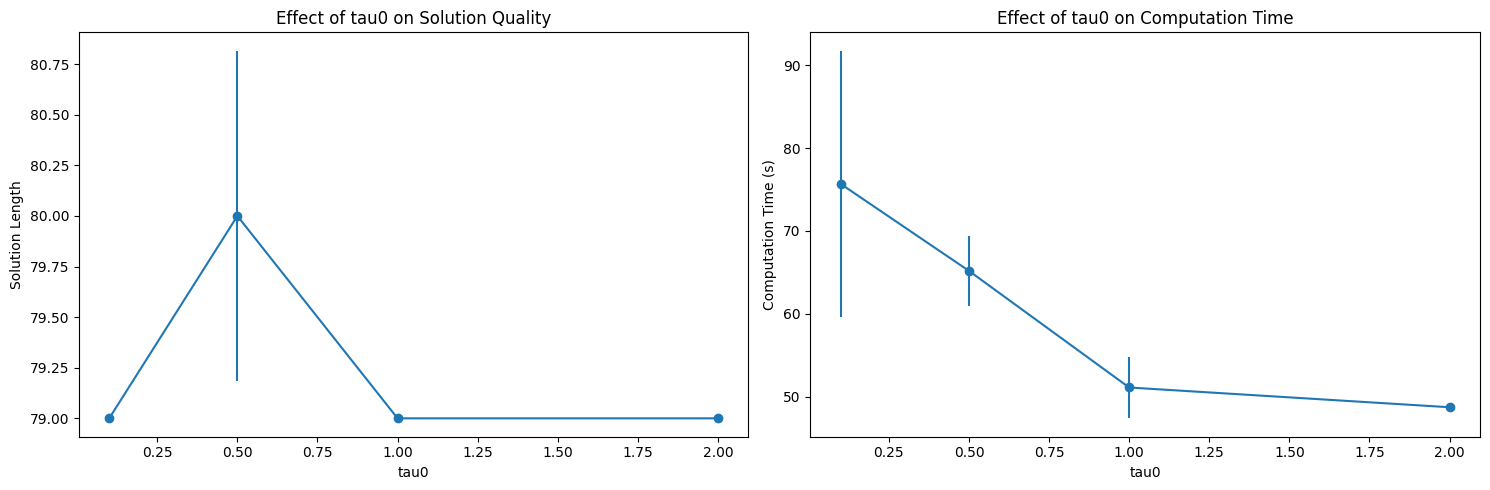

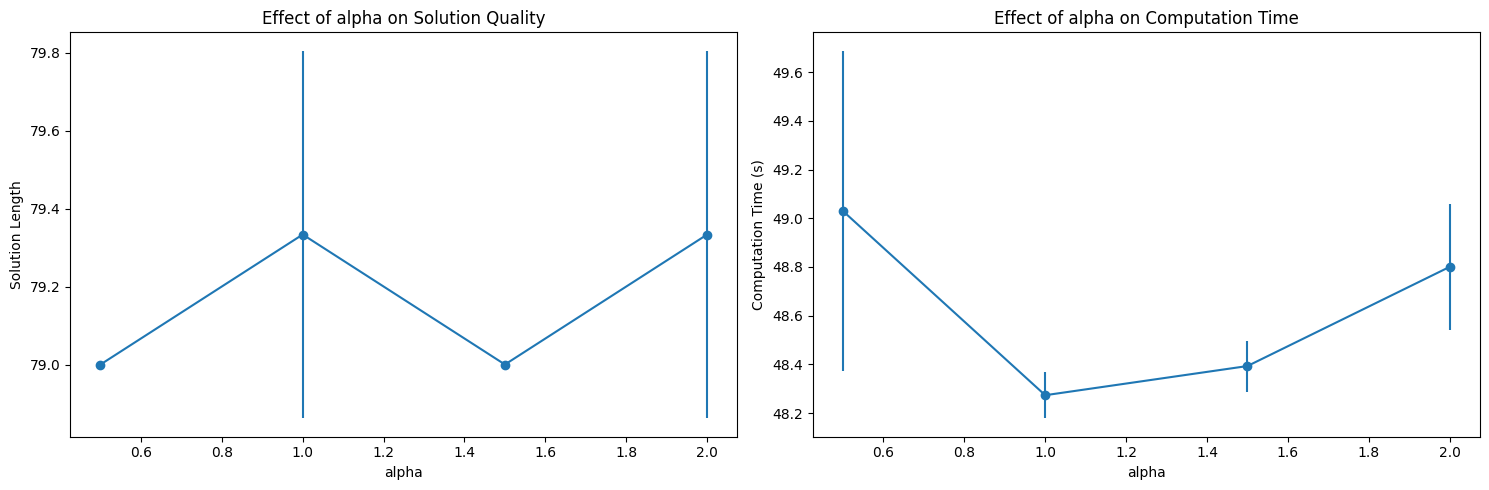

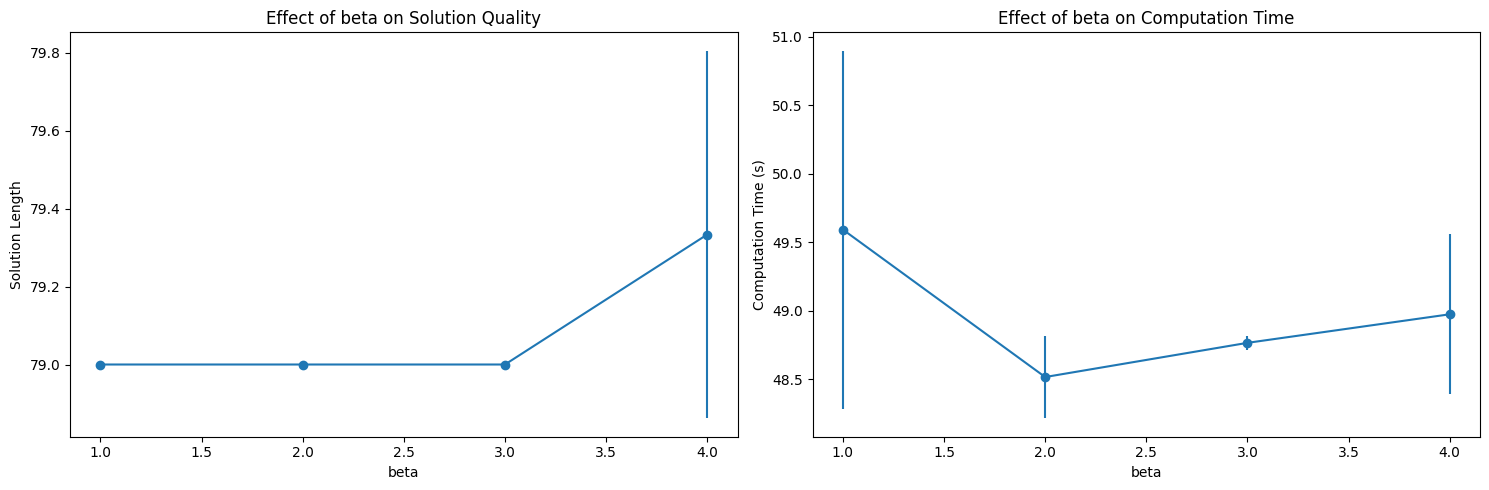

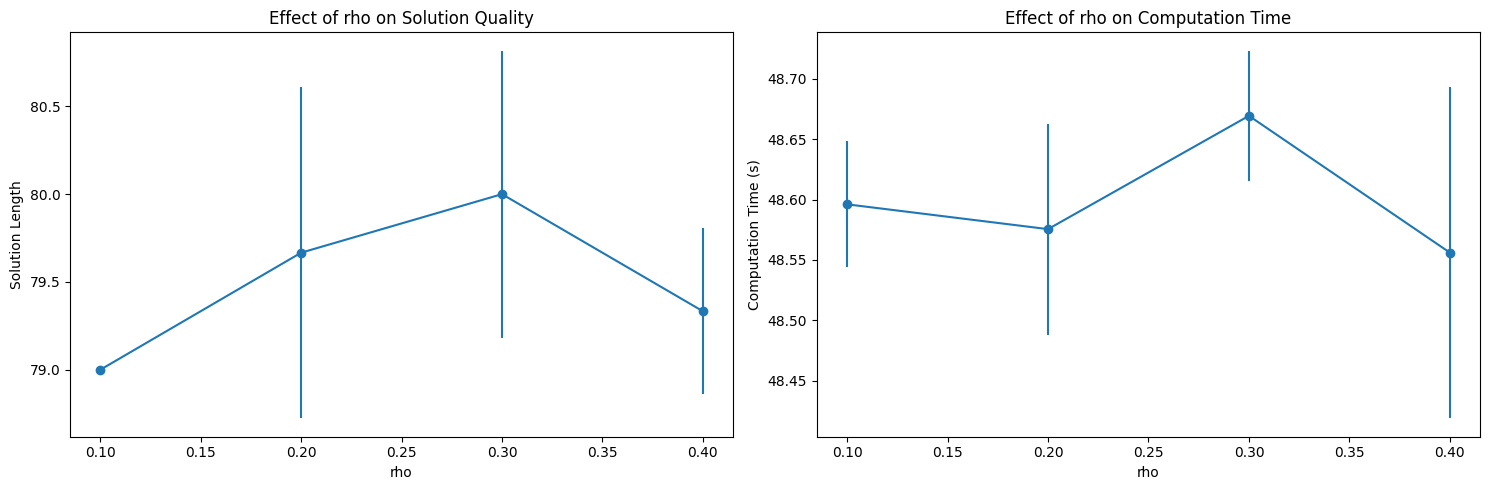

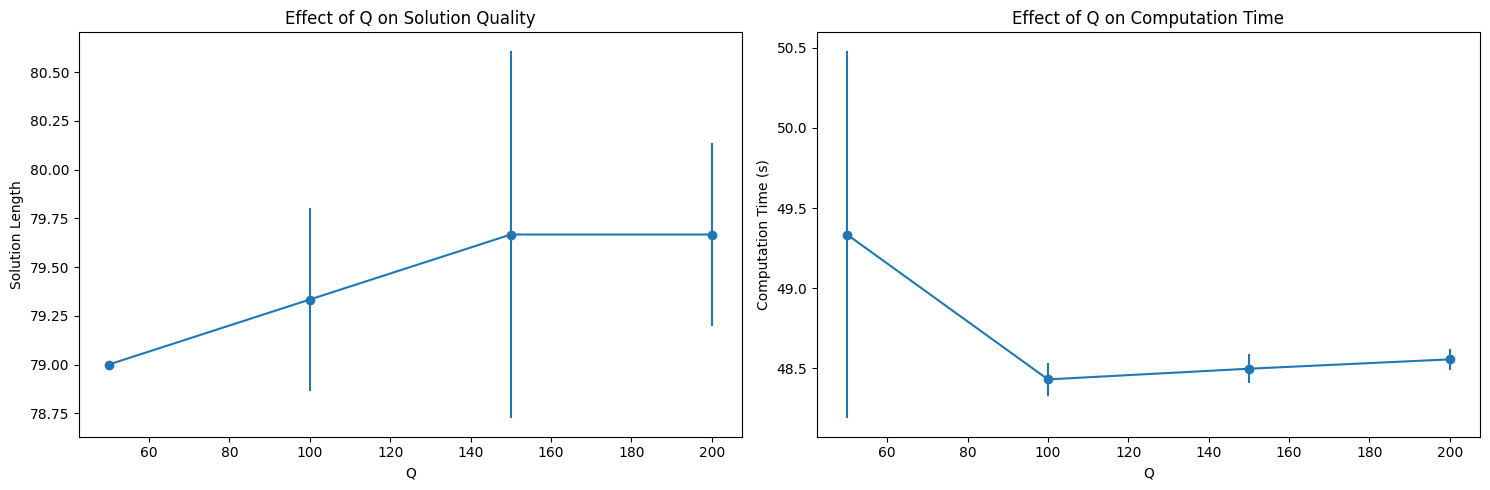

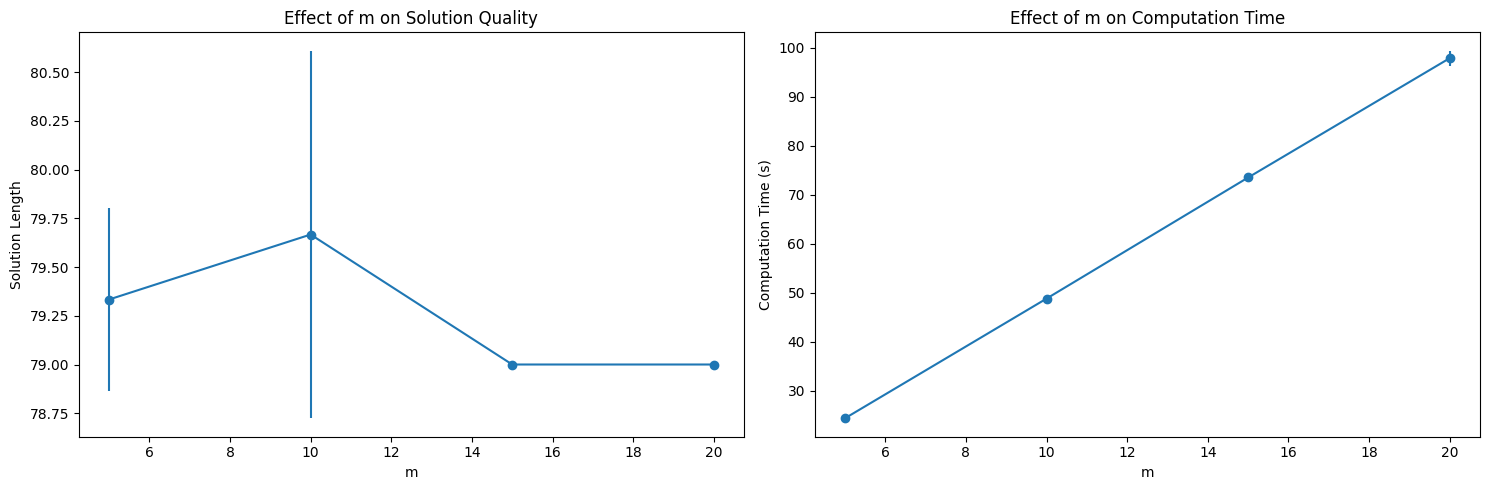

In [8]:
# CLAUDE
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
from tqdm import tqdm

class SensitivityAnalysis:
    def __init__(self, base_parameters=None):
        # Default parameter ranges for testing
        self.parameter_ranges = {
            'tau0': [0.1, 0.5, 1.0, 2.0],  # Initial pheromone levels
            'alpha': [0.5, 1.0, 1.5, 2.0],  # Pheromone influence
            'beta': [1.0, 2.0, 3.0, 4.0],   # Heuristic influence
            'rho': [0.1, 0.2, 0.3, 0.4],    # Evaporation rate
            'Q': [50, 100, 150, 200],       # Pheromone deposit constant
            'm': [5, 10, 15, 20]            # Number of ants
        }

        # Base parameters (default values if not testing)
        self.base_parameters = base_parameters or {
            'tau0': 1.0,
            'alpha': 1.0,
            'beta': 2.0,
            'rho': 0.1,
            'Q': 100,
            'm': 10
        }

        self.results = []

    def run_single_test(self, params, num_runs=3):
        """Run multiple tests with the same parameters and average the results"""
        lengths = []
        times = []

        for _ in range(num_runs):
            # Update global parameters
            global ALPHA, BETA, RHO, Q, NUM_ANTS
            ALPHA = params['alpha']
            BETA = params['beta']
            RHO = params['rho']
            Q = params['Q']
            NUM_ANTS = params['m']

            # Initialize pheromone levels with tau0
            global initialize_pheromone_levels
            def modified_initialize_pheromone_levels(n, _):
                return np.ones((n, n)) * params['tau0']

            # Run the optimization
            best_solution, best_length, total_time = ant_colony_optimization(data)

            lengths.append(best_length)
            times.append(total_time)

        return np.mean(lengths), np.std(lengths), np.mean(times), np.std(times)

    def run_sensitivity_analysis(self, parameter_to_vary=None):
        """Run sensitivity analysis varying one parameter at a time or all parameters"""
        if parameter_to_vary:
            # Vary single parameter
            test_params = self.base_parameters.copy()
            for value in self.parameter_ranges[parameter_to_vary]:
                test_params[parameter_to_vary] = value
                mean_length, std_length, mean_time, std_time = self.run_single_test(test_params)
                self.results.append({
                    'parameter': parameter_to_vary,
                    'value': value,
                    'mean_length': mean_length,
                    'std_length': std_length,
                    'mean_time': mean_time,
                    'std_time': std_time
                })
        else:
            # Full factorial analysis
            param_names = list(self.parameter_ranges.keys())
            param_values = list(self.parameter_ranges.values())

            for values in tqdm(list(product(*param_values))):
                test_params = dict(zip(param_names, values))
                mean_length, std_length, mean_time, std_time = self.run_single_test(test_params)
                result = {
                    'parameter': 'all',
                    'mean_length': mean_length,
                    'std_length': std_length,
                    'mean_time': mean_time,
                    'std_time': std_time,
                    **test_params
                }
                self.results.append(result)

    def get_results_df(self):
        """Convert results to pandas DataFrame"""
        return pd.DataFrame(self.results)

    def plot_single_parameter_sensitivity(self, parameter):
        """Plot the effect of a single parameter on solution quality"""
        df = pd.DataFrame([r for r in self.results if r['parameter'] == parameter])

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Plot solution quality
        ax1.errorbar(df['value'], df['mean_length'],
                    yerr=df['std_length'], fmt='o-')
        ax1.set_xlabel(parameter)
        ax1.set_ylabel('Solution Length')
        ax1.set_title(f'Effect of {parameter} on Solution Quality')

        # Plot computation time
        ax2.errorbar(df['value'], df['mean_time'],
                    yerr=df['std_time'], fmt='o-')
        ax2.set_xlabel(parameter)
        ax2.set_ylabel('Computation Time (s)')
        ax2.set_title(f'Effect of {parameter} on Computation Time')

        plt.tight_layout()
        return fig

def run_full_sensitivity_analysis():
    """Run a complete sensitivity analysis and return results"""
    # Initialize sensitivity analysis
    sa = SensitivityAnalysis()

    # Run analysis for each parameter individually
    for param in sa.parameter_ranges.keys():
        print(f"\nAnalyzing sensitivity to {param}...")
        sa.run_sensitivity_analysis(param)

    # Get results as DataFrame
    results_df = sa.get_results_df()

    # Create summary statistics
    summary_stats = []
    for param in sa.parameter_ranges.keys():
        param_results = results_df[results_df['parameter'] == param]
        best_value = param_results.loc[param_results['mean_length'].idxmin()]
        worst_value = param_results.loc[param_results['mean_length'].idxmax()]

        summary_stats.append({
            'parameter': param,
            'best_value': best_value['value'],
            'best_length': best_value['mean_length'],
            'worst_value': worst_value['value'],
            'worst_length': worst_value['mean_length'],
            'sensitivity': (worst_value['mean_length'] - best_value['mean_length']) / best_value['mean_length'] * 100
        })

    summary_df = pd.DataFrame(summary_stats)

    return sa, results_df, summary_df

# Run the analysis
if __name__ == "__main__":
    print("Starting sensitivity analysis...")
    sa, results_df, summary_df = run_full_sensitivity_analysis()

    print("\nResults Summary:")
    print(summary_df.to_string(index=False))

    # Plot results for each parameter
    for param in sa.parameter_ranges.keys():
        fig = sa.plot_single_parameter_sensitivity(param)
        plt.show()